In [1]:
%matplotlib inline
import sys
import time
import random

from concurrent.futures import ProcessPoolExecutor

import numpy as np
import seaborn as sns
import pandas as pd
import xgboost as xgb
import cv2
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

from mpl_toolkits.mplot3d import Axes3D
from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE

import features

from dataset import read_datasets, read_leap_motion_data
from features import extract_features, extract_lp_features, hog_single
from train import precision_for, train_clf, feature_precisions, predict_img
from utils import print_log, set_cache, get_cache, find_best_params, pca_accuracy

%load_ext autoreload
%autoreload 2

c:\users\wujie\appdata\local\programs\python\python35\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Dataset Load
persons = read_leap_motion_data('LP_data/dataset', load_cache=True)

LP_data/dataset\P1\G1
LP_data/dataset\P1\G10
LP_data/dataset\P1\G2
LP_data/dataset\P1\G3
LP_data/dataset\P1\G4
LP_data/dataset\P1\G5
LP_data/dataset\P1\G6
LP_data/dataset\P1\G7
LP_data/dataset\P1\G8
LP_data/dataset\P1\G9
LP_data/dataset\P10\G1
LP_data/dataset\P10\G10
LP_data/dataset\P10\G2
LP_data/dataset\P10\G3
LP_data/dataset\P10\G4
LP_data/dataset\P10\G5
LP_data/dataset\P10\G6
LP_data/dataset\P10\G7
LP_data/dataset\P10\G8
LP_data/dataset\P10\G9
LP_data/dataset\P11\G1
LP_data/dataset\P11\G10
LP_data/dataset\P11\G2
LP_data/dataset\P11\G3
LP_data/dataset\P11\G4
LP_data/dataset\P11\G5
LP_data/dataset\P11\G6
LP_data/dataset\P11\G7
LP_data/dataset\P11\G8
LP_data/dataset\P11\G9
LP_data/dataset\P12\G1
LP_data/dataset\P12\G10
LP_data/dataset\P12\G2
LP_data/dataset\P12\G3
LP_data/dataset\P12\G4
LP_data/dataset\P12\G5
LP_data/dataset\P12\G6
LP_data/dataset\P12\G7
LP_data/dataset\P12\G8
LP_data/dataset\P12\G9
LP_data/dataset\P13\G1
LP_data/dataset\P13\G10
LP_data/dataset\P13\G2
LP_data/dataset\

In [3]:
# Feature Extraction
X = []
y = []
X_limg = []
X_rimg = []
indices = []
for p in persons:
    print('Processing {}'.format(p))
    for g_idx in range(1, 11):
        for idx in range(1, 21):
            g = 'G{}'.format(g_idx)
            d = persons[p][g][idx]
            if not d:
                continue
            X_limg.append(hog_single(d['leye']))
            X_rimg.append(hog_single(d['reye']))
            f = extract_lp_features(d['json'])
            X.append(f)
            y.append(g_idx-1)
            indices.append((p, g, idx))
X = np.array(X)
y = np.array(y)

# Norm D and E
den = X[:, 7][:, None]
den[den == 0] = 1e9  # Infinity
X[:, 5:15] = X[:, 5:15] / den # dividing the values for the distance between the hand center and the middle fingertip S

# Norm T
den = np.max(X[:, 15:25], axis=1)[:, None]
den[den == 0] = 1e9
X[:, 15:25] = X[:, 15:25] / den

X[X < 1e-5] = 0

all_data = pd.DataFrame(np.append(X, y.reshape((-1, 1)), axis=1))
all_data.to_csv('caches/feature_set.csv', index=False, float_format='%.3f')
all_data

Processing P13
Processing P9
Processing P4
Processing P1
Processing P7
Processing P5
Processing P6
Processing P11
Processing P10
Processing P3
Processing P12
Processing P8
Processing P2


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
1,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
2,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
6,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
7,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
8,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0


In [4]:
%%time
hog_feature = hog_single(persons['P2']['G9'][5]['leye'])
print(hog_feature.shape)

(7056,)
Wall time: 7 ms


In [5]:
X_train, X_test, X_limg_train, X_limg_test, X_rimg_train, X_rimg_test, y_train, y_test = train_test_split(
    X, X_limg, X_rimg, y, test_size=0.2)

In [6]:
# Train Best clf for numerical data
features_selection = features.F_A | features.F_D | features.F_T

deletes = []
if not (features_selection & features.F_T):
    deletes.extend(range(15, 25))
if not (features_selection & features.F_E):
    deletes.extend(range(10, 15))
if not (features_selection & features.F_D):
    deletes.extend(range(5, 10))
if not (features_selection & features.F_A):
    deletes.extend(range(0, 5))       
    
selected_X_train = np.delete(X_train, deletes, axis=1)

selected_X_test = np.delete(X_test, deletes, axis=1)

In [7]:
best_num_params = {'C': 1000, 'gamma': 1}
# best_num_params = find_best_params(selected_X_train, y_train, label='One vs One SVM on num data')

In [8]:
num_clf = OneVsOneClassifier(SVC(**best_num_params), n_jobs=-1)
num_clf.fit(selected_X_train, y_train)
    
num_preds = num_clf.predict(selected_X_test)
num_accuracy = accuracy_score(num_preds, y_test)

print('Accuracy on test set: {:7.2%}'.format(num_accuracy))

Accuracy on test set:  84.62%


In [9]:
num_clf = train_clf(X_train, y_train, features_selection, test_size=0.2, ITER_TIMES=10,
                classifier='svm', params=best_num_params)
deletes = []
if not (features_selection & features.F_T):
    deletes.extend(range(15, 25))
if not (features_selection & features.F_E):
    deletes.extend(range(10, 15))
if not (features_selection & features.F_D):
    deletes.extend(range(5, 10))
if not (features_selection & features.F_A):
    deletes.extend(range(0, 5))       
    
A = np.delete(X_train, deletes, axis=1)
h_numerical = num_clf.predict(A)
A = np.delete(X_test, deletes, axis=1)
h_numerical_test = num_clf.predict(A)

# set_cache(clf, 'prfediction_model')


Accuracy on numerical train set : 85.82%
Accuracy on numerical test set  : 85.00%


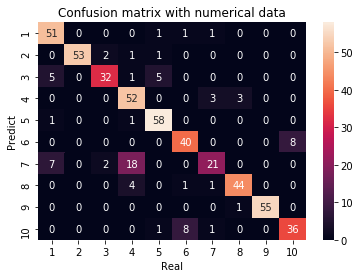

In [10]:
num_confusion_mat = np.zeros((10, 10))
for i, j in zip(y_test, h_numerical_test.astype(int)):
    num_confusion_mat[i][j] += 1
sns.heatmap(num_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with numerical data')
num_accuracy = accuracy_score(h_numerical_test, y_test)
print()
print('Accuracy on numerical train set : {:.2%}'.format(accuracy_score(h_numerical, y_train)))
print('Accuracy on numerical test set  : {:.2%}'.format(num_accuracy))

In [11]:
# One vs One SVM for pixel data
X_ltrain_h, X_ltest_h, X_rtrain_h, X_rtest_h, y_train_h, y_test_h = train_test_split(
    X_limg_train, X_rimg_train, y_train, test_size=0.15)

X_train_h = np.append(np.array(X_ltrain_h), np.array(X_rtrain_h), axis=1)
X_test_h = np.append(np.array(X_ltest_h), np.array(X_rtest_h), axis=1)

use_pca = True
if use_pca:
    pca = PCA(0.99)
    X_train_h_pca = pca.fit_transform(X_train_h)
    X_test_h_pca = pca.transform(X_test_h)

In [12]:
# %%time
# best_pix_params = find_best_params(X_train_h_pca, y_train_h, label='One vs One SVM on pix data')
best_pix_params = {'C': 10, 'gamma': 0.1}

In [13]:
pix_clf = OneVsOneClassifier(SVC(**best_pix_params), n_jobs=-1)
pix_clf.fit(X_train_h_pca, y_train_h)
    
pix_preds = pix_clf.predict(X_test_h_pca)
pix_accuracy = accuracy_score(pix_preds, y_test_h)

print('Accuracy on CV set: {:7.2%}'.format(pix_accuracy))

Accuracy on CV set:  91.67%


Accuracy on pixel train set  : 99.04%
Accuracy on pixel test set  : 91.67%


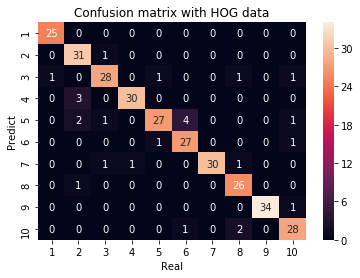

In [14]:
h_img_train = pix_clf.predict(X_train_h_pca)
h_img_test = pix_clf.predict(X_test_h_pca)
hog_confusion_mat = np.zeros((10, 10))
for i, j in zip(y_test_h, h_img_test.astype(int)):
    hog_confusion_mat[i][j] += 1
sns.heatmap(hog_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with HOG data')
print('Accuracy on pixel train set  : {:.2%}'.format(accuracy_score(h_img_train, y_train_h)))
print('Accuracy on pixel test set  : {:.2%}'.format(accuracy_score(h_img_test, y_test_h)))

In [15]:
%%time
pix_res = []

for p in range(100, 79, -1):
    percent = p / 100
    if abs(percent - 1) < 1e-5:
        DECOMPOSITION = False
    else:
        DECOMPOSITION = True
    pca = PCA(percent)

    # Train set
    _train = X_train_h
    if DECOMPOSITION:
        _train = pca.fit_transform(_train)
    if pix_res and _train.shape[1] == pix_res[-1][1]:
        continue
        
    # Test set
    _test = X_test_h
    if DECOMPOSITION:
        _test = pca.transform(_test)
        
    all_clf = OneVsOneClassifier(SVC(**best_pix_params), n_jobs=-1)
    all_clf.fit(_train, y_train_h)
    
    h_combine = all_clf.predict(_test)
    score = accuracy_score(h_combine, y_test_h)
        
    _res = (percent, _test.shape[1], score)
    pix_res.append(_res)
    print('Variance retained: {:7.2%}, Dimensions retained: {:6d}, Accuracy: {:7.2%}'.format(*_res))

Variance retained: 100.00%, Dimensions retained:  14112, Accuracy:  91.67%
Variance retained:  99.00%, Dimensions retained:    387, Accuracy:  91.67%
Variance retained:  98.00%, Dimensions retained:    303, Accuracy:  91.67%
Variance retained:  97.00%, Dimensions retained:    251, Accuracy:  91.35%
Variance retained:  96.00%, Dimensions retained:    215, Accuracy:  91.35%
Variance retained:  95.00%, Dimensions retained:    187, Accuracy:  91.03%
Variance retained:  94.00%, Dimensions retained:    164, Accuracy:  91.35%
Variance retained:  93.00%, Dimensions retained:    146, Accuracy:  91.03%
Variance retained:  92.00%, Dimensions retained:    130, Accuracy:  91.03%
Variance retained:  91.00%, Dimensions retained:    117, Accuracy:  91.03%
Variance retained:  90.00%, Dimensions retained:    106, Accuracy:  90.71%
Variance retained:  89.00%, Dimensions retained:     96, Accuracy:  90.38%
Variance retained:  88.00%, Dimensions retained:     88, Accuracy:  89.74%
Variance retained:  87.00

Max:   91.67%


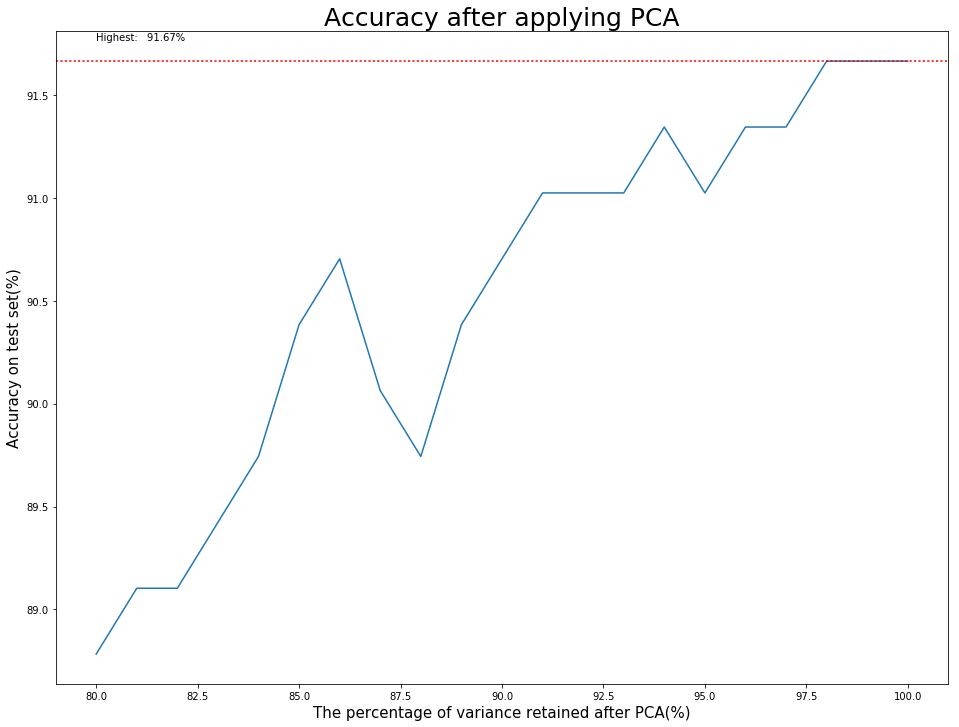

In [16]:
rres = [(k[0]*100, k[2]*100) for k in pix_res]
rres_x = [k[0] for k in rres]
rres_y = [k[1] for k in rres]

all_accuracy = max(rres_y)
print('Max: {:7.2f}%'.format(all_accuracy))
      
plt.figure(figsize=(16, 12))
plt.plot(rres_x, rres_y)
plt.xlabel('The percentage of variance retained after PCA(%)', fontsize=15)
plt.ylabel('Accuracy on test set(%)', fontsize=15)
# plt.ylim((90, 100))
# plt.xlim((70, 100))
plt.axhline(y=all_accuracy, xmin=0, xmax=100, color='r', linestyle='dotted')
plt.text(min(rres_x), all_accuracy+0.1, 'Highest: {:7.2f}%'.format(all_accuracy))
plt.title('Accuracy after applying PCA', fontsize=25)

In [17]:
# Combine numerical data and pixel data
Xnum_train = np.array(selected_X_train)
Ximg_train = np.append(np.array(X_limg_train), np.array(X_rimg_train), axis=1)
Xc_train_1x_hog = np.append(Xnum_train, Ximg_train, axis=1)
Xc_train_2x_hog = np.append(Xnum_train, 2 * Ximg_train, axis=1)

Xnum_test = np.array(selected_X_test)
Ximg_test = np.append(np.array(X_limg_test), np.array(X_rimg_test), axis=1)
Xc_test = np.append(Xnum_test, Ximg_test, axis=1)
Xc_test_1x_hog = np.append(Xnum_test, Ximg_test, axis=1)
Xc_test_2x_hog = np.append(Xnum_test, 2 * Ximg_test, axis=1)

In [18]:
%%time
best_all_params = {'C': 10, 'gamma': 0.1}

# Find best params for all data
X_grid = Xc_train_1x_hog

use_pca = False
if use_pca:
    pca = PCA(0.99)
    X_grid = pca.fit_transform(X_grid)
    
# best_all_params = find_best_params(X_grid, y_train, label='One vs One SVM on all data')

Wall time: 0 ns


In [19]:
%%time
coef_res = {}
for coef in range(1, 10):
    print('Coef: {}'.format(coef))
    Xc_train = np.append(Xnum_train, coef * Ximg_train, axis=1)
    Xc_test = np.append(Xnum_test, coef * Ximg_test, axis=1)
    res = pca_accuracy(Xc_train, y_train, Xc_test, y_test, 100, 60, best_all_params)
    coef_res[coef] = res

Coef: 1
Variance retained: 100.00%, Dimensions retained:  14132, Accuracy:  98.27%
Variance retained:  99.00%, Dimensions retained:    258, Accuracy:  98.27%
Variance retained:  98.00%, Dimensions retained:    169, Accuracy:  98.27%
Variance retained:  97.00%, Dimensions retained:    122, Accuracy:  97.88%
Variance retained:  96.00%, Dimensions retained:     94, Accuracy:  97.50%
Variance retained:  95.00%, Dimensions retained:     75, Accuracy:  97.31%
Variance retained:  94.00%, Dimensions retained:     61, Accuracy:  97.12%
Variance retained:  93.00%, Dimensions retained:     51, Accuracy:  96.92%
Variance retained:  92.00%, Dimensions retained:     44, Accuracy:  96.73%
Variance retained:  91.00%, Dimensions retained:     38, Accuracy:  96.35%
Variance retained:  90.00%, Dimensions retained:     34, Accuracy:  96.35%
Variance retained:  89.00%, Dimensions retained:     30, Accuracy:  96.15%
Variance retained:  88.00%, Dimensions retained:     27, Accuracy:  95.96%
Variance retained

KeyboardInterrupt: 

c:\users\wujie\appdata\local\programs\python\python35\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


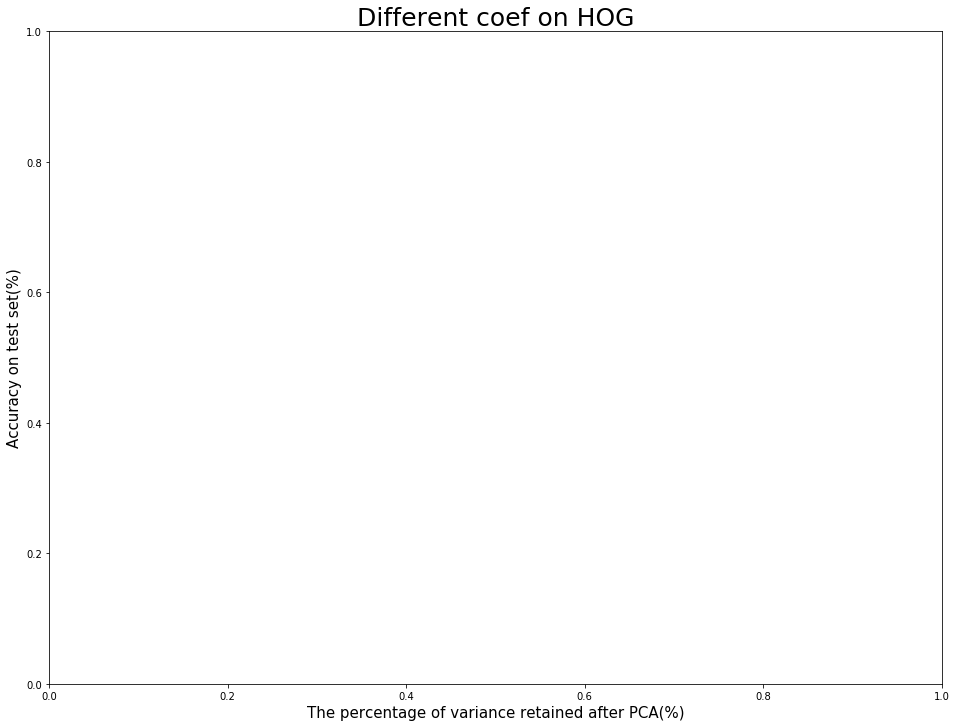

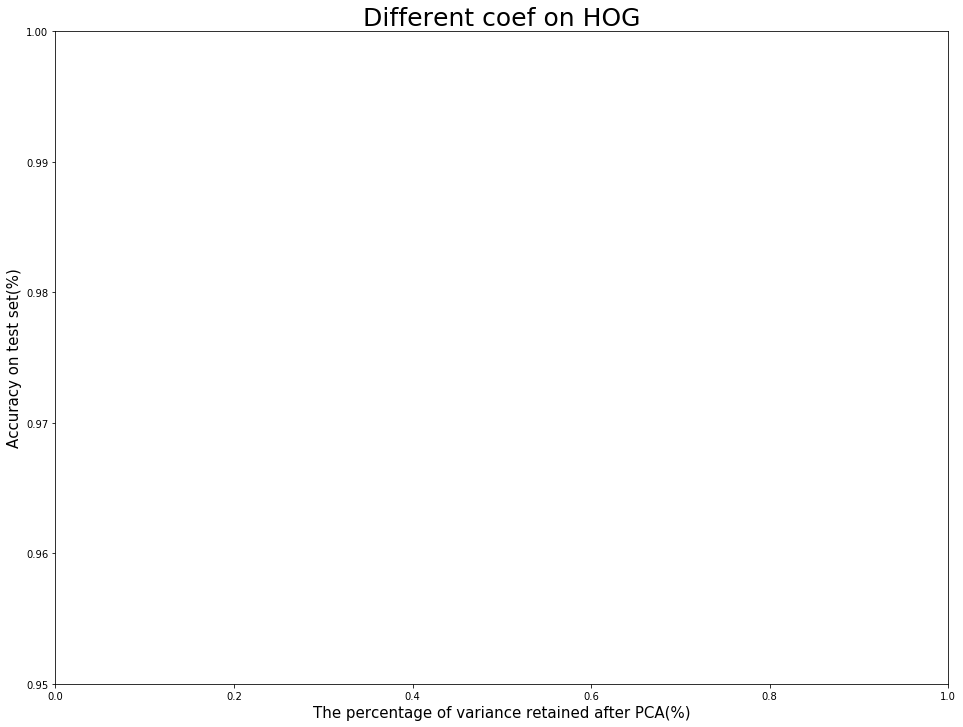

In [20]:
plt.figure(figsize=(16, 12))
colors = sns.color_palette("hls", 9)
for idx, (coef, res) in enumerate(coef_res.items()):
    res_x = [k[0] for k in res]
    res_y = [k[2] for k in res]
    plt.plot(res_x, res_y, label='{}X HOG'.format(coef), color=colors[idx])
    plt.text(res_x[0] + random.uniform(0, 0.02), res_y[0], '{}X'.format(coef))
plt.xlabel('The percentage of variance retained after PCA(%)', fontsize=15)
plt.ylabel('Accuracy on test set(%)', fontsize=15)
plt.title('Different coef on HOG', fontsize=25)
plt.legend()

plt.figure(figsize=(16, 12))
colors = sns.color_palette("hls", 9)
for idx, (coef, res) in enumerate(coef_res.items()):
    res_x = [k[0] for k in res]
    res_y = [k[2] for k in res]
    plt.plot(res_x, res_y, label='{}X HOG'.format(coef), color=colors[idx])
    plt.text(res_x[0] + random.uniform(0, 0.05), max(0.95, res_y[0]), '{}X'.format(coef))
plt.xlabel('The percentage of variance retained after PCA(%)', fontsize=15)
plt.ylabel('Accuracy on test set(%)', fontsize=15)
plt.ylim((0.95, 1))
plt.title('Different coef on HOG', fontsize=25)
plt.legend()

In [21]:
# Train set
pca = PCA(0.99)

_train = Xc_train_1x_hog
if DECOMPOSITION:
    _train = pca.fit_transform(_train)

_test = Xc_test_1x_hog
if DECOMPOSITION:
    _test = pca.transform(_test)

all_clf = OneVsOneClassifier(SVC(**best_all_params), n_jobs=-1)
all_clf.fit(_train, y_train)

h_combine = all_clf.predict(_train).astype(int)
h_combine_test = all_clf.predict(_test).astype(int)


Combined features accuracy on train set : 99.71%
Combined features accuracy on test set  : 98.27%


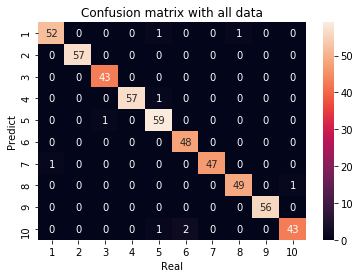

In [ ]:
tot_confusion_mat = np.zeros((10, 10))
for i, j in zip(y_test, h_combine_test):
    tot_confusion_mat[i][j] += 1
sns.heatmap(tot_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with all data')
print()
print('Combined features accuracy on train set : {:.2%}'.format(accuracy_score(h_combine, y_train)))
print('Combined features accuracy on test set  : {:.2%}'.format(accuracy_score(h_combine_test, y_test)))

In [ ]:
# Train set
pca = PCA(0.99)

_train = Xc_train_2x_hog
if DECOMPOSITION:
    _train = pca.fit_transform(_train)

_test = Xc_test_2x_hog
if DECOMPOSITION:
    _test = pca.transform(_test)

all_clf = OneVsOneClassifier(SVC(**best_all_params), n_jobs=-1)
all_clf.fit(_train, y_train)

h_combine = all_clf.predict(_train).astype(int)
h_combine_test = all_clf.predict(_test).astype(int)

In [ ]:
tot_confusion_mat = np.zeros((10, 10))
for i, j in zip(y_test, h_combine_test):
    tot_confusion_mat[i][j] += 1
sns.heatmap(tot_confusion_mat, annot=True, xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.xlabel('Real')
plt.ylabel('Predict')
plt.title('Confusion matrix with all data')
print()
print('Combined features accuracy on train set : {:.2%}'.format(accuracy_score(h_combine, y_train)))
print('Combined features accuracy on test set  : {:.2%}'.format(accuracy_score(h_combine_test, y_test)))